# Predict Remaining Useful Lifetime (RUL) on a NASA Turbofan Engine Degradation Simulation Data Set

This predictive maintanance model is part of a University Project  of the course *Machine Learning in Mechanics* at the University of the Stuttgart.

The models were created by <br>
- Fabian Moeller,
- Felix Bode,
- Vincent Hackstein.

## Preprocessing and Function Integrity Checks
This notebook shows our Preprocessing workflow and calls custom function and checks them for integrity. <br>
Please refer to the notebooks `Regression.ipynb` and `Classification.ipynb` for details about the models.


In [1]:
SUBWINDOW_LENGTH = 50
SUBWINDOWS = 50  # can be ignored if 'MAXIMIZE_SUBWINDOWS' is set on True
MAXIMIZE_SUBWINDOWS = True    
WINDOW_LENGTH = 100
SUBWINDOW_TARGET = "min"      # Defines target within subwindow

#DEVICE = "cuda"
DEVICE = "cpu"
MAX_EPOCHS = 5


TARGET_CLIP_UPPER = False
TARGET_MAX = 125              # maximum RUL-value for each `unit_number`
TARGET_CLIP_LOWER = False
TARGET_MIN = 10               # minimum RUL-value for each `unit_number`

## Import of predefined functions

If you run this Notebook on Google colab, the installation of skorch might be neccessary

In [2]:
onColab = False

# install skorch on colab notebooks if required
if onColab:
    ! [ ! -z "$COLAB_GPU" ] && pip install torch torchvision pillow==4.1.1 skorch

    from google.colab import drive
    import os

    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive')


In [3]:
from datetime import datetime
import math
import numpy as np
from pathlib import Path
import pickle
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import sys
import time
from tqdm import tqdm

import ipywidgets as widgets
from ipywidgets import interact

#from IPython.display import clear_output

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

##  Custom function imports
E.g. functions to save figures, change colormap
We provide a notebook `function_integrity.ipynb` where the functions were tested for integrity.

In [4]:
from plotting_lib import return_current_date_and_time, truncate_colormap, save_figure,\
    plot_correlation_heatmap, plot_samples_over_feature, plot_all_features_for_all_units,\
        plot_percentage_of_removed_cycles, plot_colorbar, plot_samples_in_test_and_rul_dataset,\
            plot_mse_and_rul_scoring_function, plot_signal_contributions_of_pcs, plot_retained_variance,\
                plot_categories_over_pc_1_and_2


from data_preprocessing import subdivide_dataframe_by_feature, add_target_feature, create_coherent_windows,\
    get_subwindows_from_window, get_subwindows_from_dataframes, subdivide_indices_of_a_list,\
        normalize_feature_values, pipeline_level_0, pipeline_level_2

## Import data from .txt-Files
The Data can be downloaded from [NASA's Prognostics Center of Excellence](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan).

In [5]:
FEATURES = ["operational_setting_%s" %i for i in range(1, 4)] +\
           ["sensor_measurement_%s" %i for i in range(1, 22)]

COLUMN_LABELS = ["unit_number", "time_in_cycles"] + FEATURES
SENSOR_FEATURES = COLUMN_LABELS[5:]

path_cands = [r"..\CMAPSSData",
              r".\CMAPSSData",
              r"CMAPSSData"]

path = [path for path in path_cands if Path(path).exists()][0]

INPUT_FILE_RUL = "RUL_FD001.txt"
INPUT_FILE_TRAIN = "train_FD001.txt"
INPUT_FILE_TEST = "test_FD001.txt"

'''
INPUT_FILE_RUL = "RUL_FD002.txt"
INPUT_FILE_TRAIN = "train_FD002.txt"
INPUT_FILE_TEST = "test_FD002.txt"
'''

INPUT_FILE_RUL = pd.read_csv(path + "/" + INPUT_FILE_RUL, header=None, names=["RUL_FD001"])
INPUT_FILE_RUL = INPUT_FILE_RUL["RUL_FD001"]

def from_csv(file):
    kwargs = dict(header=None, delim_whitespace=True, names=COLUMN_LABELS)
    data = pd.read_csv(file, **kwargs)
    return data

INPUT_FILE_TRAIN = from_csv(path + "/" + INPUT_FILE_TRAIN)
INPUT_FILE_TEST = from_csv(path + "/" + INPUT_FILE_TEST)




---
# Data Preprocessing and Descriptive Statistics

The following cells present multiple functions and their arguments for data preprocessing.
Finally, the whole data preprocessing workflow can be executed by the functions `pipeline_level_0` or `pipeline_level_2`

### Ratio of withholded Remaining Useful Lifetime to last time cycle in test dataset
In contrast to the training dataset (`INPUT_FILE_TRAIN`) the last (= max) cycle in the test dataset (`INPUT_FILE_TEST`)  is not equal to the cycle when maintenance is required.

To get this final cycle it is necessary to add the information given in `INPUT_FILE_RUL` to the test dataset's `time_in_cycles`.

*(For participants of a challenge the information given in `INPUT_FILE_RUL` was withholded.)*

Figure not saved


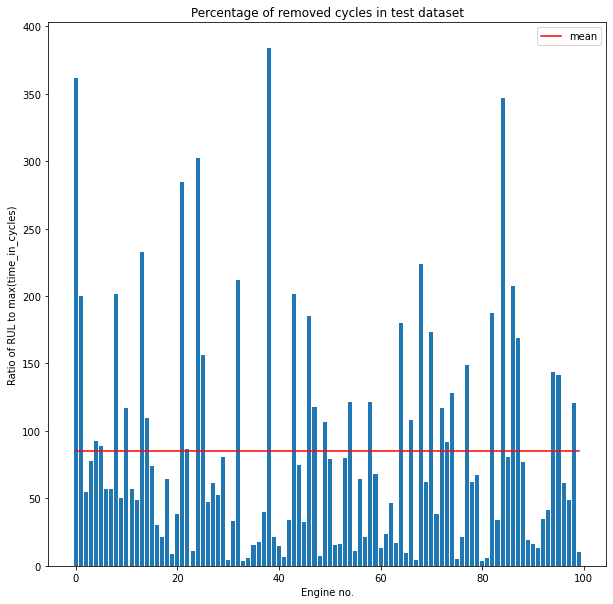

In [6]:
plot_percentage_of_removed_cycles(input_file_rul=INPUT_FILE_RUL,
                                  input_file_test=INPUT_FILE_TEST)

Plot cycles in dataset `INPUT_FILE_RUL` together with cycles in dataset `INPUT_FILE_TEST`

Figure not saved


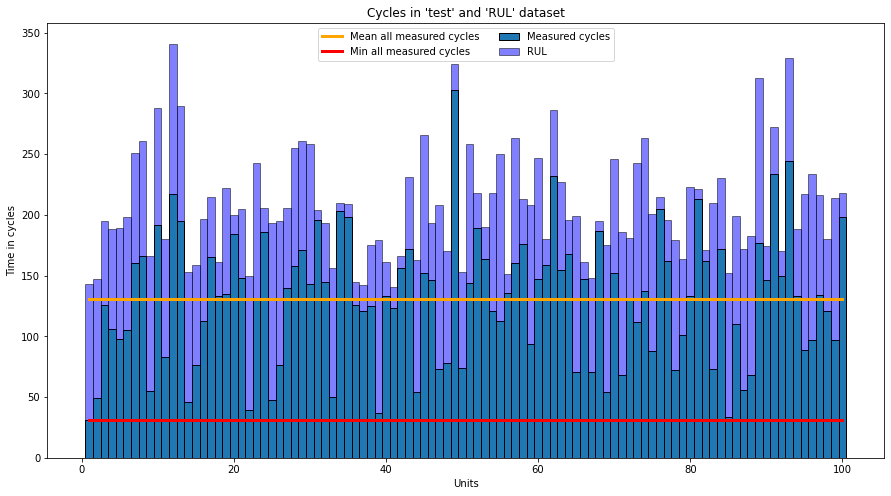

In [7]:
plot_samples_in_test_and_rul_dataset(input_file_test=INPUT_FILE_TEST,
                                     input_file_rul=INPUT_FILE_RUL)

### Correlation heatmap

Plot the correlation heatmap for the sensor measurments of the training set.

Figure not saved


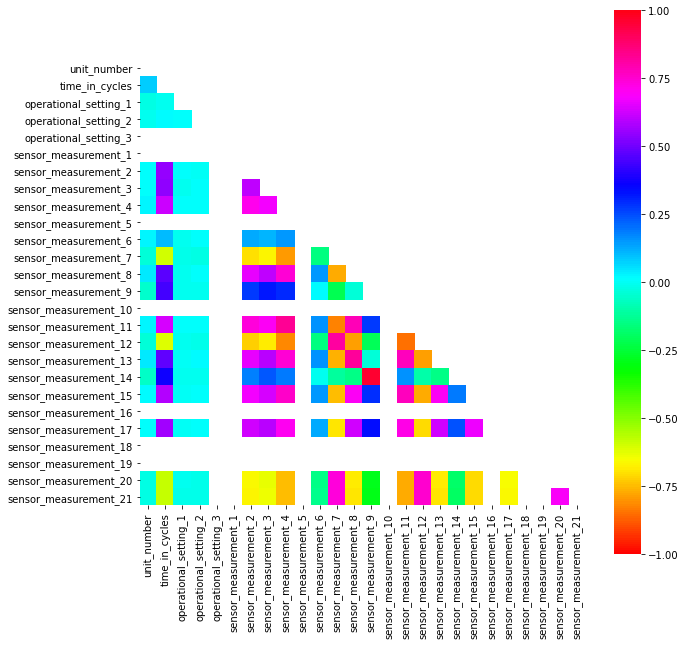

In [8]:
plot_correlation_heatmap(input_file=INPUT_FILE_TRAIN)

## Define RUL Score
The RUL ('Remaning Useful Lifetime') Score is an indicator function which measures the performance of an RUL estimation. It is used in RUL estimation related [publications](https://www.researchgate.net/publication/330254823_Remaining_Useful_Life_Estimation_in_Prognostics_Using_Deep_Bidirectional_LSTM_Neural_Network) and PHM Competitions.
The definition of the scoring function is as follows: <br>

\begin{equation}
  D_{it} =
    \begin{cases}
      \sum_{i=1}^n  \exp(-\frac{h_i}{13}) - 1 &, h_i < 0 \\
      \sum_{i=1}^n \exp(-\frac{h_i}{10}) -1 &, h_i \ge 0 \\
    \end{cases}       
\end{equation} <br>
\begin{align}
      \text{with } h_i = \mathit{RUL}_{pred, i} - \mathit{RUL}_{gt, i}
\end{align}


Herein $RUL_{pred, i}$ stands for the remaining useful lifetime predicted with the regression model for an evaluated sample *$i$* out of *$n$* samples.

$RUL_{gt, i}$ is the underlying ground truth.


As shown in the following figure, the RUL-score adds weight especially to differences *$h_i \geq 0$* in contrast to the root mean squared error function $$RMSE = \sqrt{\frac{1}{n} \cdot \sum_{i}^{n} h_i^2}$$

Figure not saved


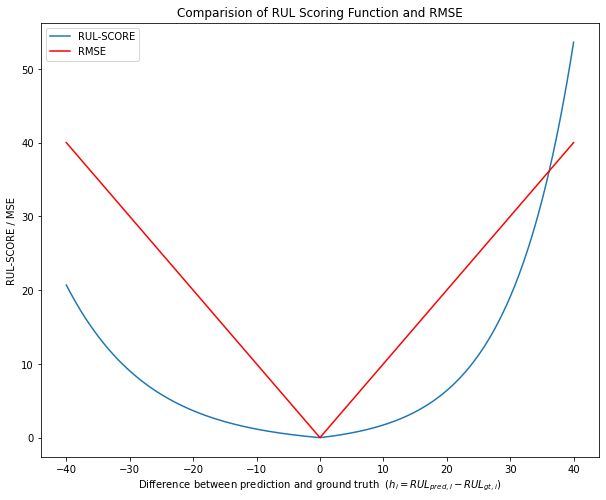

In [9]:
plot_mse_and_rul_scoring_function()

## Create list of dataframes

In [10]:
list_of_dataframes = subdivide_dataframe_by_feature(INPUT_FILE_TRAIN)
print(len(list_of_dataframes))

100


### Validate function 'subdivide_dataset_by_feature':
- Is subdivision according to unit-number implemented correctly?

In [11]:
feature = "unit_number"

list_of_dataframes = subdivide_dataframe_by_feature(INPUT_FILE_TRAIN,
                                                    feature)

train_data_units = INPUT_FILE_TRAIN[feature].unique()
for list_index, unit in enumerate(train_data_units):
    assert (INPUT_FILE_TRAIN[INPUT_FILE_TRAIN[feature] == unit] == list_of_dataframes[list_index]).all().all()

## Define target values for regression for list of dataframes
- Add 'target'-feature to a single dataframe (entry from 'list_of_dataframes')
- Target feature can be:
    - RUL ("Remaining useful lifetime" = Timedelta): Last timestamp minus current timestamp
    - Remaining cycles: last cycle minuns current cycle

### Validate function 'add_target_feature' for list of dataframes

In [12]:
list_of_dataframes = subdivide_dataframe_by_feature(INPUT_FILE_TRAIN)

for dataframe in list_of_dataframes:
    add_target_feature(dataframe,
                       target_clip_upper=TARGET_CLIP_UPPER)


selected_df = list_of_dataframes[0]
# assert (selected_df.time_in_cycles.iloc[-1] - selected_df.time_in_cycles.iloc[0]) == selected_df.target.iloc[0]

selected_df.head()

,unit_number,time_in_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,target
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191.0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190.0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189.0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188.0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187.0


### Validate function 'add_target_feature' for timeseries (pd.Timestamps)

In [13]:
test_df = pd.date_range(start="1/1/2018", periods=10, freq="1 h")
test_df = pd.DataFrame(test_df, columns=["Time"])


add_target_feature(test_df,
                   regression_feature="Time")

test_df

,Time,target
0,2018-01-01 00:00:00,9.0
1,2018-01-01 01:00:00,8.0
2,2018-01-01 02:00:00,7.0
3,2018-01-01 03:00:00,6.0
4,2018-01-01 04:00:00,5.0
5,2018-01-01 05:00:00,4.0
6,2018-01-01 06:00:00,3.0
7,2018-01-01 07:00:00,2.0
8,2018-01-01 08:00:00,1.0
9,2018-01-01 09:00:00,0.0


## Plot histogram: number of samples per `unit_number`

Figure not saved


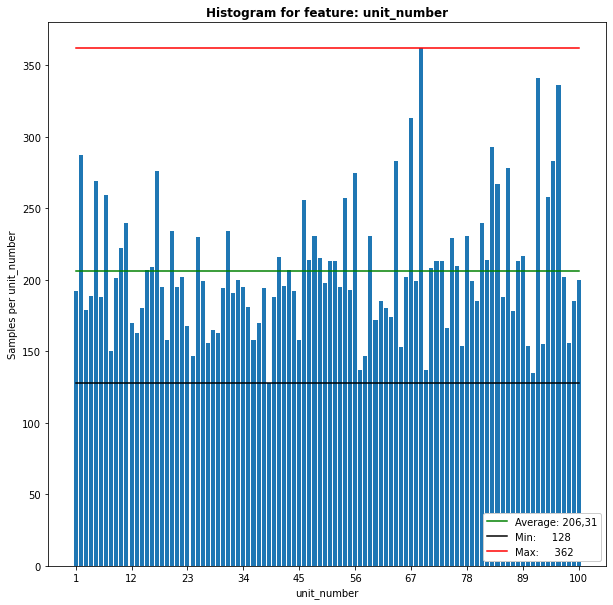

In [14]:
plot_samples_over_feature(INPUT_FILE_TRAIN,
                          feature="unit_number",
                          saving_path=r".\Plots",
                          save_fig=False,
                          plot_format="pdf")

## Plot all features over time for a specific unit / for all units

  1%|          | 1/100 [00:00<01:35,  1.03it/s]/Users/Vinz/Documents/Uni Stuttgart lokal/Master/MLMech/Project_on_github/Predictive-Maintenance/plotting_lib.py:318: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axis = plt.subplot(g[row_index, col_index])
100%|██████████| 100/100 [00:25<00:00,  3.96it/s]


Figure not saved


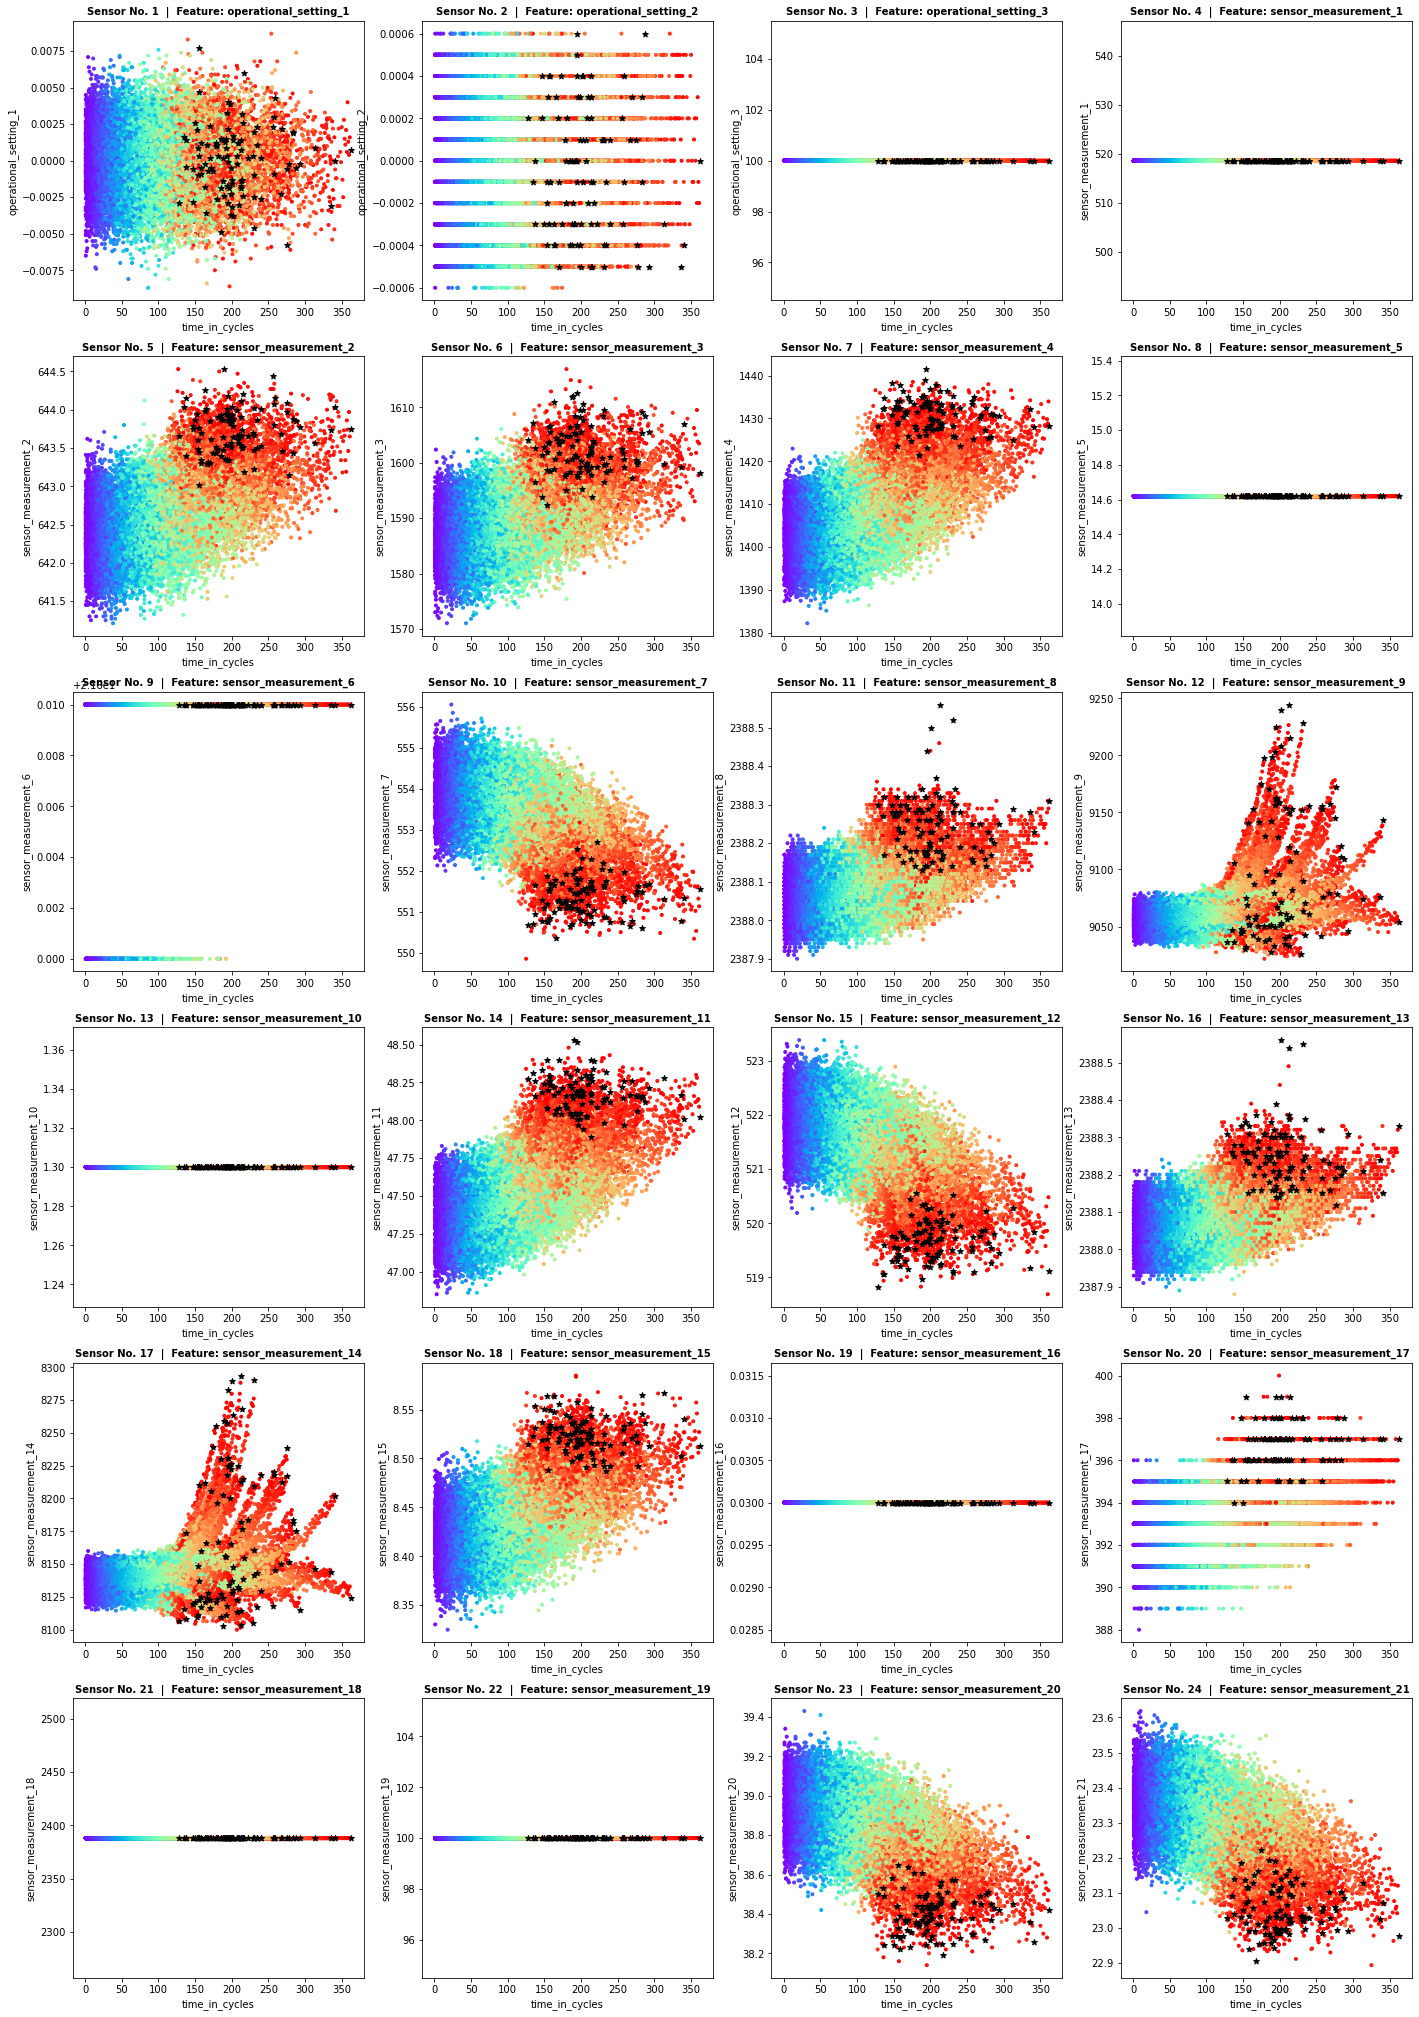

In [15]:
plot_all_features_for_all_units(list_of_dataframes,
                                features=FEATURES,
                                colormap_feature="time_in_cycles",
                                number_of_columns=4,
                                saving_path=r".\Plots",
                                save_fig=False,
                                plot_format="png")

### Plot colorbar to explain colormap in plot above

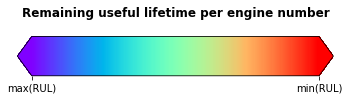

In [18]:
cmap = plt.cm.rainbow
cmap_ticks = [0, 1]
cmap_ticklabels = ["max(RUL)", "min(RUL)"]
title = "Remaining useful lifetime per engine number"


plot_colorbar(cmap=cmap,
              cmap_ticks=cmap_ticks,
              cmap_ticklabels=cmap_ticklabels,
              figure_size=(5, 1.5),
              title=title,
              saving_path=r"Plots",
              save_fig=True,
              plot_format="pdf")

## Create coherent windows per dataframe
- Result is a list of dataframes made out of a single dataframe
- list entries are so called 'windows'. A window is a coherent subset of a dataset without interruptions, for example due to interruptions during measurements.
- The data within a window (subset) can be regarded as complete
- A window must have a minimum sample size (argument 'min_window')
- $\color{green}{\text{Since all windows are coherent into this dataset, creating windows is optional -> Only one window per dataframe (subset).}}$


### Validate function 'create_coherent_windows'
- Therefore manipulate coherent dataset only for test purpose

In [19]:
test_df = list_of_dataframes[0]
test_df_indices = test_df.index

np.random.seed(42)
used_indices = np.random.choice(test_df_indices,
                                size=int(0.8 * len(test_df)),
                                replace=False)
used_indices.sort()
#print(used_indices)
#print("Used indices [%]:\t", round(100 * len(used_indices) / len(test_df_indices), 2))

unused_indices = np.setdiff1d(test_df_indices, used_indices)
print("Unused loc-indices (%s):\n" % len(unused_indices), unused_indices)

test_df_reduced = test_df.iloc[used_indices]
window_list = create_coherent_windows(test_df_reduced,
                                      min_window=10,
                                      print_output=True)

Unused loc-indices (39):
 [  1  14  20  21  37  48  50  52  54  57  58  63  71  74  87  88  92  99
 102 103 106 107 116 121 129 130 134 149 151 157 160 167 168 176 179 181
 185 188 191]

Start (iloc):	 0 	End (iloc) - exclusive:	 1 	Width:	 1
Start (loc):	 0 	End (loc) - inclusive:	 0
Window can't be used due to window lenght

Start (iloc):	 1 	End (iloc) - exclusive:	 13 	Width:	 12
Start (loc):	 2 	End (loc) - inclusive:	 13

Start (iloc):	 13 	End (iloc) - exclusive:	 18 	Width:	 5
Start (loc):	 15 	End (loc) - inclusive:	 19
Window can't be used due to window lenght

Start (iloc):	 18 	End (iloc) - exclusive:	 33 	Width:	 15
Start (loc):	 22 	End (loc) - inclusive:	 36

Start (iloc):	 33 	End (iloc) - exclusive:	 43 	Width:	 10
Start (loc):	 38 	End (loc) - inclusive:	 47

Start (iloc):	 43 	End (iloc) - exclusive:	 44 	Width:	 1
Start (loc):	 49 	End (loc) - inclusive:	 49
Window can't be used due to window lenght

Start (iloc):	 44 	End (iloc) - exclusive:	 45 	Width:	 1
Start (l

In [20]:
test_df = list_of_dataframes[0]
window_list = create_coherent_windows(test_df,
                                      min_window=200,
                                      print_output=True)
print(len(test_df))
if window_list != None:
    print(len(window_list))
else: 
    print(window_list)

There's no gap between single measurements and splitting in windows is not necessary

DataFrame can't be used
192
None


## Create subwindows from windows
- Arguments for 'subwindow_target':
    - 'min': take minimum of target-series in subwindow as target value for whole subwindow
    - 'max': take maximum of target-series in subwindow as target value for whole subwindow
    - 'mean': take mean of target-series in subwindow as target value for whole subwindow

#### $\color{green}{\text{Done:}}$
- Check that there are no duplicates in subwindows in case 'maximize_subwindows=False' and sort indices correctly, so that shuffle makes sense?
 -> Workaround: New implementation for 'start_index'

### Validate function 'get_subwindows_from_window'
- Also test of stacking multiple subwindows created from multiple windows

In [21]:
# Create list of dataframes
list_of_dataframes = subdivide_dataframe_by_feature(INPUT_FILE_TRAIN)

# Add target values to each dataframe
for dataframe in list_of_dataframes:
    add_target_feature(dataframe,
                       target_clip_upper=TARGET_CLIP_UPPER,
                       target_max=TARGET_MAX)

test_df = list_of_dataframes[0]
test_window_list = create_coherent_windows(test_df)
test_window_df = test_window_list[0]

feature_values_per_window_1, target_values_per_window_1 = get_subwindows_from_window(test_window_df,
                                                                                     features=FEATURES,
                                                                                     subwindow_target="min",
                                                                                     maximize_subwindows=True,
                                                                                     shuffle=False)

feature_values_per_window_2, target_values_per_window_2 = get_subwindows_from_window(test_window_df,
                                                                                     features=FEATURES,
                                                                                     subwindow_target="mean",
                                                                                     shuffle=False)

print("Samples in window_df:\t\t\t", len(test_window_df), "\n")
print("Shape 'feature_values_per_window_1':\t", feature_values_per_window_1.shape)
print("Shape 'target_values_per_window_1':\t", target_values_per_window_1.shape)

print("Shape 'feature_values_per_window_2':\t", feature_values_per_window_2.shape)
print("Shape 'target_values_per_window_2':\t", target_values_per_window_2.shape)
print("\n")
#print("\n", target_values_per_window_1)
#print("\n", target_values_per_window_2)

# Test stacking / concatenating
all_feature_values = np.vstack([feature_values_per_window_1, feature_values_per_window_2])
all_target_values = np.vstack([target_values_per_window_1, target_values_per_window_2])
print("Shape 'all_feature_values':\t\t", all_feature_values.shape)
print("Shape 'all_target_values':\t\t", all_target_values.shape)

assert target_values_per_window_2[0] == all_target_values[target_values_per_window_1.shape[0]]


# Try reproducing "unit_number" for each subwindow
feature_values_per_window_2, engine_number = get_subwindows_from_window(test_window_df,
                                                                        features=FEATURES,
                                                                        target_feature="unit_number",
                                                                        shuffle=False)

engine_number = np.concatenate(engine_number).astype(int)
print(engine_number)

Samples in window_df:			 192 

Shape 'feature_values_per_window_1':	 (142, 24, 50)
Shape 'target_values_per_window_1':	 (142, 1)
Shape 'feature_values_per_window_2':	 (32, 24, 50)
Shape 'target_values_per_window_2':	 (32, 1)


Shape 'all_feature_values':		 (174, 24, 50)
Shape 'all_target_values':		 (174, 1)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


## Split into train-, test-, validation subset

Definition of a function for the subdivision of the whole dataset to a training, a validation and a test subset. 
The training dataset's purpose is to train the model. The validation dataset is used for the best selection of a model out of all training iterations, whereas the test dataset won't be used during the training process. Its purpose is to finally evaluate the best model.  
All subsets don't have a common intersection. This means that a single measurement can only be found once in one of the subsets.

#### Used functions:
- https://numpy.org/doc/stable/reference/generated/numpy.setdiff1d.html
- https://pandas.pydata.org/docs/reference/api/pandas.Series.isin.html


#### Different possibilities for subdivision:
- Split list_of_dataframes completely: a specific unit will only be used in the training, validation OR test subset
- Split after creating all subwindows from each dataframe (subset): subwindows of a specific unit can be found in training, validation AND test subset


- Level 0: Separate whole dataframes from others and for no other subset
- Level 1: Separate whole windows (out of dataframes) from other windows; windows of all dataframes could be found in all subsets; $\color{red}{\text{Not implemented yet, since windows are coherent in this dataset}}$
- Level 2: Separate subwindows; subwindows of all dataframes could be found in all subsets

### Function for Level 0 and Level 2:

#### Validate function 'get_subwindows_from_dataframes'

In [22]:
# Create list of dataframes
list_of_dataframes = subdivide_dataframe_by_feature(INPUT_FILE_TRAIN)

# Add target values to each dataframe
for dataframe in list_of_dataframes:
    add_target_feature(dataframe,
                       target_clip_upper=TARGET_CLIP_UPPER,
                       target_max=TARGET_MAX)


all_time_in_cycles, all_target_values = get_subwindows_from_dataframes(list_of_dataframes,
                                                                       features=["time_in_cycles"],
                                                                       subwindow_length=SUBWINDOW_LENGTH,
                                                                       maximize_subwindows=True)
all_time_in_cycles = np.concatenate(all_time_in_cycles).astype(int)


all_feature_values, all_unit_numbers = get_subwindows_from_dataframes(list_of_dataframes,
                                                                      features=FEATURES,
                                                                      target_feature="unit_number",
                                                                      subwindow_length=SUBWINDOW_LENGTH,
                                                                      maximize_subwindows=True)

all_unit_numbers = all_unit_numbers.astype(int)

print("Number of dataframes:\t\t", len(list_of_dataframes))
print("Shape 'all_feature_values':\t", all_feature_values.shape)
print("Shape 'all_time_in_cycles':\t", all_time_in_cycles.shape)
print("Shape 'all_target_values':\t", all_target_values.shape)
print("Shape 'all_unit_numbers':\t", all_unit_numbers.shape)

Generating Subwindows: 100%|██████████| 100/100 [00:22<00:00,  4.45it/s]

Number of dataframes:		 100
Shape 'all_feature_values':	 (15631, 24, 50)
Shape 'all_time_in_cycles':	 (15631, 50)
Shape 'all_target_values':	 (15631, 1)
Shape 'all_unit_numbers':	 (15631, 1)


### Level 0: Function to separate whole dataframes from others

#### Validate function 'subdivide_indices_of_a_list'

In [23]:
# Create list of dataframes
list_of_dataframes = subdivide_dataframe_by_feature(INPUT_FILE_TRAIN)

# Add target values to each dataframe
for dataframe in list_of_dataframes:
    add_target_feature(dataframe)

list_indices = list(range(len(list_of_dataframes)))
first_list_indices, second_list_indices = subdivide_indices_of_a_list(list_indices,
                                                                      fixed_seed=True,
                                                                      sort_lists=True)

print("'first_list_indices':                     ", first_list_indices)
print("'second_list_indices' (before splitting): ", second_list_indices)


second_list_indices, third_list_indices = subdivide_indices_of_a_list(second_list_indices,
                                                                      first_list_proportion=0.5,
                                                                      fixed_seed=True,
                                                                      sort_lists=True)

print("'second_list_indices' (after splitting):  ", second_list_indices)
print("'third_list_indices':                     ", third_list_indices)


'first_list_indices':                      [ 0  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 22 24 25 26 27 28 30
 31 33 34 35 36 38 39 40 42 43 44 45 46 47 49 50 53 54 55 56 61 62 64 65
 66 67 68 69 70 72 73 76 77 78 80 81 83 85 88 89 90 93 95 96 97 99]
'second_list_indices' (before splitting):  [ 1  2 14 20 21 23 29 32 37 41 48 51 52 57 58 59 60 63 71 74 75 79 82 84
 86 87 91 92 94 98]
'second_list_indices' (after splitting):   [ 1 21 23 37 41 51 52 57 59 60 63 84 86 92 94]
'third_list_indices':                      [ 2 14 20 29 32 48 58 71 74 75 79 82 87 91 98]


## Split according to Level 0: Separate whole dataframes from others

In [24]:
X_train, y_train = get_subwindows_from_dataframes([list_of_dataframes[i] for i in first_list_indices],
                                                  features=FEATURES)
X_test, y_test = get_subwindows_from_dataframes([list_of_dataframes[j] for j in second_list_indices],
                                                features=FEATURES)
X_val, y_val = get_subwindows_from_dataframes([list_of_dataframes[k] for k in third_list_indices],
                                              features=FEATURES)

print("Number of dataframes:\t", len(list_of_dataframes))
print("Shape 'X_train':\t", X_train.shape)
print("Shape 'X_test':\t\t", X_test.shape)
print("Shape 'X_val':\t\t", X_val.shape)

Generating Subwindows: 100%|██████████| 15/15 [00:00<00:00, 17.46it/s]

Number of dataframes:	 100
Shape 'X_train':	 (2240, 24, 50)
Shape 'X_test':		 (480, 24, 50)
Shape 'X_val':		 (480, 24, 50)


#### If additional information about subwindows is required

In [25]:
# Training dataset
time_in_cycles_train, y_train = get_subwindows_from_dataframes([list_of_dataframes[i] for i in first_list_indices],
                                                               features=["time_in_cycles"])

time_in_cycles_train = np.concatenate(time_in_cycles_train).astype(int)


X_train, unit_train = get_subwindows_from_dataframes([list_of_dataframes[i] for i in first_list_indices],
                                                     features=FEATURES,
                                                     target_feature="unit_number")

unit_train = unit_train.astype(int)

print("Shape 'X_train':\t\t", X_train.shape)
print("Shape 'time_in_cycles_train':\t", time_in_cycles_train.shape)
print("Shape 'y_train':\t\t", y_train.shape)
print("Shape 'unit_train':\t\t", unit_train.shape)


# Test dataset
time_in_cycles_test, y_test = get_subwindows_from_dataframes([list_of_dataframes[i] for i in second_list_indices],
                                                             features=["time_in_cycles"])

time_in_cycles_test = np.concatenate(time_in_cycles_test).astype(int)


X_test, unit_test = get_subwindows_from_dataframes([list_of_dataframes[i] for i in second_list_indices],
                                                   features=FEATURES,
                                                   target_feature="unit_number")

unit_test = unit_test.astype(int)

print("Shape 'X_test':\t\t\t", X_test.shape)
print("Shape 'time_in_cycles_test':\t", time_in_cycles_test.shape)
print("Shape 'y_test':\t\t\t", y_test.shape)
print("Shape 'unit_test':\t\t", unit_test.shape)


# Validation dataset
time_in_cycles_val, y_val = get_subwindows_from_dataframes([list_of_dataframes[i] for i in third_list_indices],
                                                           features=["time_in_cycles"])

time_in_cycles_val = np.concatenate(time_in_cycles_val).astype(int)


X_val, unit_val = get_subwindows_from_dataframes([list_of_dataframes[i] for i in third_list_indices],
                                                 features=FEATURES,
                                                 target_feature="unit_number")

unit_val = unit_val.astype(int)

print("Shape 'X_val':\t\t\t", X_val.shape)
print("Shape 'time_in_cycles_val':\t", time_in_cycles_val.shape)
print("Shape 'unit_val':\t\t", unit_val.shape)
print("Shape 'y_val':\t\t\t", y_val.shape)

Generating Subwindows:  20%|██        | 3/15 [00:00<00:00, 21.45it/s]

Shape 'X_train':		 (2240, 24, 50)
Shape 'time_in_cycles_train':	 (2240, 50)
Shape 'y_train':		 (2240, 1)
Shape 'unit_train':		 (2240, 1)


Generating Subwindows:  20%|██        | 3/15 [00:00<00:00, 22.94it/s]

Shape 'X_test':			 (480, 24, 50)
Shape 'time_in_cycles_test':	 (480, 50)
Shape 'y_test':			 (480, 1)
Shape 'unit_test':		 (480, 1)


Generating Subwindows: 100%|██████████| 15/15 [00:00<00:00, 19.27it/s]

Shape 'X_val':			 (480, 24, 50)
Shape 'time_in_cycles_val':	 (480, 50)
Shape 'unit_val':		 (480, 1)
Shape 'y_val':			 (480, 1)


### Level 2: Stack all subwindows created out of all windows for all dataframes (subsets) for a whole dataset

In [26]:
np.random.seed(42)

# Create list of dataframes
list_of_dataframes = subdivide_dataframe_by_feature(INPUT_FILE_TRAIN)

# Add target values to each dataframe
for dataframe in list_of_dataframes:
    add_target_feature(dataframe)

all_time_in_cycles, all_target_values = get_subwindows_from_dataframes(list_of_dataframes,
                                                                       features=["time_in_cycles"],
                                                                       subwindow_length=SUBWINDOW_LENGTH,
                                                                       subwindow_target="min",
                                                                       subwindows=40)

all_time_in_cycles = np.concatenate(all_time_in_cycles).astype(int)


all_feature_values, all_unit_numbers = get_subwindows_from_dataframes(list_of_dataframes,
                                                                      features=FEATURES,
                                                                      target_feature="unit_number",
                                                                      subwindow_length=SUBWINDOW_LENGTH,
                                                                      subwindow_target="min",
                                                                      subwindows=40)

all_unit_numbers = all_unit_numbers.astype(int)

print("Number of dataframes:          ", len(list_of_dataframes))
print("Shape 'all_feature_values':    ", all_feature_values.shape)
print("Shape 'all_time_in_cycles':    ", all_unit_numbers.shape)
print("Shape 'all_unit_numbers':      ", all_unit_numbers.shape)
print("Shape 'all_unit_numbers':      ", all_target_values.shape)

Generating Subwindows: 100%|██████████| 100/100 [00:05<00:00, 16.97it/s]

Number of dataframes:           100
Shape 'all_feature_values':     (4000, 24, 50)
Shape 'all_time_in_cycles':     (4000, 1)
Shape 'all_unit_numbers':       (4000, 1)
Shape 'all_unit_numbers':       (4000, 1)


### Reduce features to raise assertion-error in normalization

FEATURES_RED = ["unit_number", "time_in_cycles"] + [FEATURES[i] for i in [2, 3, 7, 12, 18, 20, 21]]
FEATURED_DROP = [i for i in FEATURES if i not in FEATURES_RED]

#### Create list of dataframes
list_of_dataframes = subdivide_dataframe_by_feature(INPUT_FILE_TRAIN)

for index in range(len(list_of_dataframes)):
    list_of_dataframes[index] = list_of_dataframes[index].drop(FEATURED_DROP, axis=1)

#### Add target values to each dataframe
for dataframe in list_of_dataframes:
    add_target_feature(dataframe)


all_feature_values, all_target_values = get_subwindows_from_dataframes(list_of_dataframes,
                                                                       subwindows=40,
                                                                       features=FEATURES_RED[2:])

print("Number of dataframes:\t\t", len(list_of_dataframes))
print("Shape 'all_feature_values':\t", all_feature_values.shape)

## Split according to Level 2: Separate subwindows; subwindows of all dataframes could be found in all subsets

In [27]:
list_indices = list(range(all_feature_values.shape[0]))

first_list_indices, second_list_indices = subdivide_indices_of_a_list(list_indices,
                                                                      first_list_proportion=0.5,
                                                                      fixed_seed=True,
                                                                      sort_lists=True)

second_list_indices, third_list_indices = subdivide_indices_of_a_list(second_list_indices,
                                                                      first_list_proportion=0.5,
                                                                      fixed_seed=True,
                                                                      sort_lists=True)

X_train, y_train = all_feature_values[first_list_indices], all_target_values[first_list_indices]
X_test, y_test = all_feature_values[second_list_indices], all_target_values[second_list_indices]
X_val, y_val = all_feature_values[third_list_indices], all_target_values[third_list_indices]

time_in_cycles_train, unit_train = all_time_in_cycles[first_list_indices], all_unit_numbers[first_list_indices]
time_in_cycles_test, unit_test = all_time_in_cycles[second_list_indices], all_unit_numbers[second_list_indices]
time_in_cycles_val, unit_val = all_time_in_cycles[third_list_indices], all_unit_numbers[third_list_indices]


print("Number of dataframes:         ", len(list_of_dataframes))
print("Shape 'X_train':              ", X_train.shape)
print("Shape 'y_train':              ", y_train.shape)
print("Shape 'time_in_cycles_train': ", time_in_cycles_train.shape)
print("Shape 'unit_train':           ", unit_train.shape, end="\n\n")

print("Shape 'X_test':               ", X_test.shape)
print("Shape 'y_test':               ", y_test.shape)
print("Shape 'time_in_cycles_test':  ", time_in_cycles_test.shape)
print("Shape 'unit_test':            ", unit_test.shape, end="\n\n")

print("Shape 'X_val':                ", X_val.shape)
print("Shape 'y_val':\               ", y_val.shape)
print("Shape 'time_in_cycles_val':   ", time_in_cycles_val.shape)
print("Shape 'unit_val':             ", unit_val.shape, end="\n\n")



Number of dataframes:          100
Shape 'X_train':               (2000, 24, 50)
Shape 'y_train':               (2000, 1)
Shape 'time_in_cycles_train':  (2000, 50)
Shape 'unit_train':            (2000, 1)

Shape 'X_test':                (1000, 24, 50)
Shape 'y_test':                (1000, 1)
Shape 'time_in_cycles_test':   (1000, 50)
Shape 'unit_test':             (1000, 1)

Shape 'X_val':                 (1000, 24, 50)
Shape 'y_val':\                (1000, 1)
Shape 'time_in_cycles_val':    (1000, 50)
Shape 'unit_val':              (1000, 1)



## Normalize features


### Execute function 'normalize_features'

In [28]:
X_train_norm, standardization_params = normalize_feature_values(features_array=X_train)

X_test_norm, _ = normalize_feature_values(features_array=X_test,
                                          train_standardization_params=standardization_params)

X_val_norm, _ = normalize_feature_values(features_array=X_val,
                                         train_standardization_params=standardization_params)

print("Shape 'X_train' before normalization:\t", X_train.shape)
print("Shape 'X_train' after normalization:\t", X_train_norm.shape)
print("Shape 'y_train':\t\t\t", y_train.shape)
print("\n")
print("Shape 'X_test' before normalization:\t", X_test.shape)
print("Shape 'X_test_norm' after normalization:", X_test_norm.shape)
print("Shape 'y_test':\t\t\t\t", y_test.shape)
print("\n")
print("Shape 'X_val' before normalization:\t", X_val.shape)
print("Shape 'X_val_norm' after normalization:\t", X_val_norm.shape)
print("Shape 'y_val':\t\t\t\t", y_val.shape)



Len invalid features:	 7
Invalid features are:	 [2, 3, 7, 12, 18, 20, 21] 

Len invalid features:	 7
Invalid features are:	 [2, 3, 7, 12, 18, 20, 21] 

Len invalid features:	 7
Invalid features are:	 [2, 3, 7, 12, 18, 20, 21] 

Shape 'X_train' before normalization:	 (2000, 24, 50)
Shape 'X_train' after normalization:	 (2000, 17, 50)
Shape 'y_train':			 (2000, 1)


Shape 'X_test' before normalization:	 (1000, 24, 50)
Shape 'X_test_norm' after normalization: (1000, 17, 50)
Shape 'y_test':				 (1000, 1)


Shape 'X_val' before normalization:	 (1000, 24, 50)
Shape 'X_val_norm' after normalization:	 (1000, 17, 50)
Shape 'y_val':				 (1000, 1)


## $\color{green}{\text{Complete Pipeline according to level 0}}$
**Level 0**: Separate whole dataframes from others. Subwidows for a specific `unit_number` are *included exclusively* within the `test`, `training` or `validation` dataset

In [29]:
pipeline_kwargs = dict(input_file=INPUT_FILE_TRAIN,
                       subwindow_features=FEATURES,
                       min_window_length=WINDOW_LENGTH,
                       subwindows=SUBWINDOWS,
                       subwindow_length=SUBWINDOW_LENGTH,
                       subwindow_target=SUBWINDOW_TARGET,
                       maximize_subwindows=MAXIMIZE_SUBWINDOWS,
                       shuffle_subwindows=True,
                       percentage_training=50,
                       percentage_test=25,
                       splitting_feature="unit_number",
                       regression_feature="time_in_cycles",
                       target_feature_name="target",
                       target_clip_lower=TARGET_CLIP_LOWER,
                       target_min=TARGET_MIN,
                       target_clip_upper=TARGET_CLIP_UPPER,
                       target_max=TARGET_MAX,
                       fixed_dataframe_assignment=True,
                       sort_dataframes_after_splitting=False)
'''
X_train_norm, y_train, time_in_cycles_train, unit_train,\
    X_test_norm, y_test, time_in_cycles_test, unit_test,\
        X_val_norm, y_val, time_in_cycles_val, unit_val, norm_parameter_regression = pipeline_level_0(**pipeline_kwargs)
'''

'\nX_train_norm, y_train, time_in_cycles_train, unit_train,    X_test_norm, y_test, time_in_cycles_test, unit_test,        X_val_norm, y_val, time_in_cycles_val, unit_val, norm_parameter_regression = pipeline_level_0(**pipeline_kwargs)\n'

## $\color{blue}{\text{Complete Pipeline according to level 2}}$
**Level 2**: Subwidows for a specific `unit_number` can be found within the `test`, `training` or `validation` dataset

In [30]:
pipeline_kwargs = dict(input_file=INPUT_FILE_TRAIN,
                       subwindow_features=FEATURES,
                       min_window_length=WINDOW_LENGTH,
                       subwindows=SUBWINDOWS,
                       subwindow_length=SUBWINDOW_LENGTH,
                       subwindow_target=SUBWINDOW_TARGET,
                       maximize_subwindows=MAXIMIZE_SUBWINDOWS,
                       shuffle_subwindows=True,
                       percentage_training=50,
                       percentage_test=25,
                       splitting_feature="unit_number",
                       regression_feature="time_in_cycles",
                       target_feature_name="target",
                       target_clip_lower=TARGET_CLIP_LOWER,
                       target_min=TARGET_MIN,
                       target_clip_upper=TARGET_CLIP_UPPER,
                       target_max=TARGET_MAX,
                       fixed_dataframe_assignment=True,
                       sort_dataframes_after_splitting=False)

X_train_norm, y_train, time_in_cycles_train, unit_train,\
    X_test_norm, y_test, time_in_cycles_test, unit_test,\
        X_val_norm, y_val, time_in_cycles_val, unit_val, norm_parameter_regression = pipeline_level_0(**pipeline_kwargs)

Chosen splitting [%]:
Training:           50
Test:               25
Validation:         25


Generating Subwindows: 100%|██████████| 25/25 [00:04<00:00,  5.39it/s]


Len invalid features:	 7
Invalid features are:	 [2, 3, 7, 12, 18, 20, 21] 

Len invalid features:	 7
Invalid features are:	 [2, 3, 7, 12, 18, 20, 21] 

Len invalid features:	 7
Invalid features are:	 [2, 3, 7, 12, 18, 20, 21] 

Number of dataframes:                     100

Shape 'X_train' after normalization:      (7892, 17, 50)
Shape 'X_test_norm' after normalization:  (3667, 17, 50)
Shape 'X_val_norm' after normalization:   (4072, 17, 50)


#### Representation of Subwindows as maps

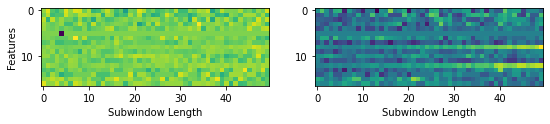

In [31]:
randint = np.random.randint(low=0, high=X_train_norm.shape[0], size=2)
fig, ax = plt.subplots(1, 2, figsize=(9,2))
ax[0].set_ylabel("Features");
for i, l in enumerate(randint):
    ax[i].imshow(X_train_norm[l])
    ax[i].set_xlabel("Subwindow Length");
    